# Pulse Analysis

Getting the idea from [[1]](#ref_1) to use a error function (the integral of a gaussian) as the shape of pulse to evaluate the relation between its rise time (RT) and bandwidth (BW). The cumulative distribution function of a gaussian [[2]](#ref_2), $\Phi \left( \frac{x - \mu}{\sigma} \right)$, is defined as:

$\Phi \left( \frac{x - \mu}{\sigma} \right) = \frac{1}{2} \left[ 1 + erf\left( \frac{x - \mu}{\sigma \sqrt{2}} \right) \right]$

Where:

$erf\left( x \right) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^{2}}dt$

Lets start checking the [erf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erf.html), the [erfc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfc.html#scipy.special.erfc), and [erfinv](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfinv.html) functions provided by the SciPy library [[3]](#ref_3). 

In [20]:
# importing some useful libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy import special
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import windows

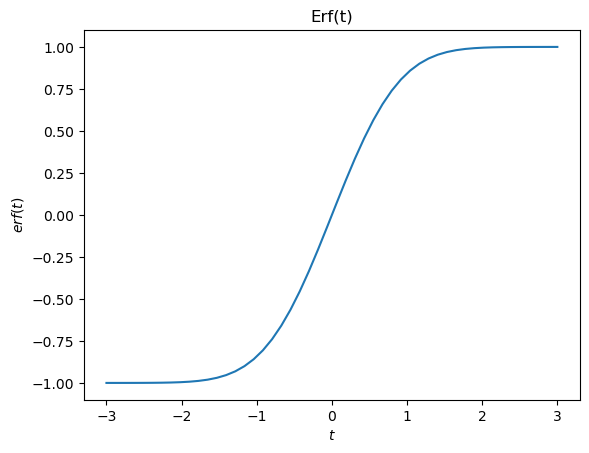

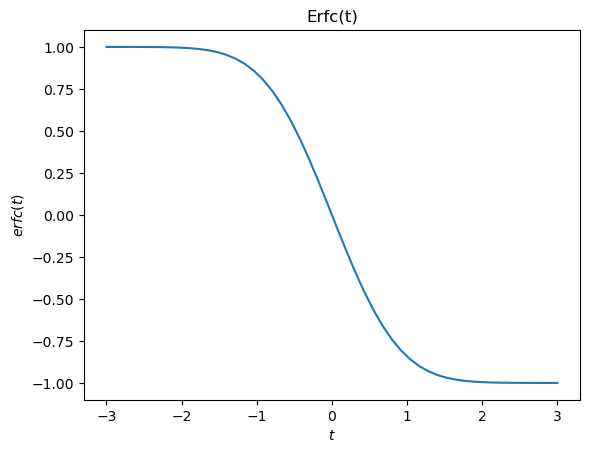

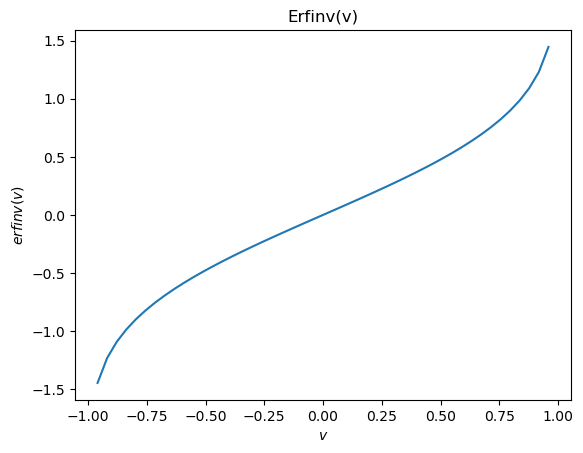

In [2]:
# visualizing the erf and erfinv
t = np.linspace(-3, 3)
plt.plot(t, special.erf(t))
plt.xlabel('$t$')
plt.ylabel('$erf(t)$')
plt.title('Erf(t)')
plt.show()

t = np.linspace(-3, 3)
plt.plot(t, special.erfc(t)-1) # it needed to - 1 to keep the simetry
plt.xlabel('$t$')
plt.ylabel('$erfc(t)$')
plt.title('Erfc(t)')
plt.show()

v = np.linspace(-1, 1)
plt.plot(v, special.erfinv(v))
plt.xlabel('$v$')
plt.ylabel('$erfinv(v)$')
plt.title('Erfinv(v)')
plt.show()

Now, lets define the [gaussian CDF](https://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution_function) (phi) to be the shape of our pulse and, its inverse (phiinv), also known as [quantile function](https://en.wikipedia.org/wiki/Normal_distribution#Quantile_function) as an auxiliary function, to calculate the rise time (10-90%) of our pulse. The pulse will be caracterized by its $\mu$ and $\sigma$, which will be tweaked to get the desired rise times.

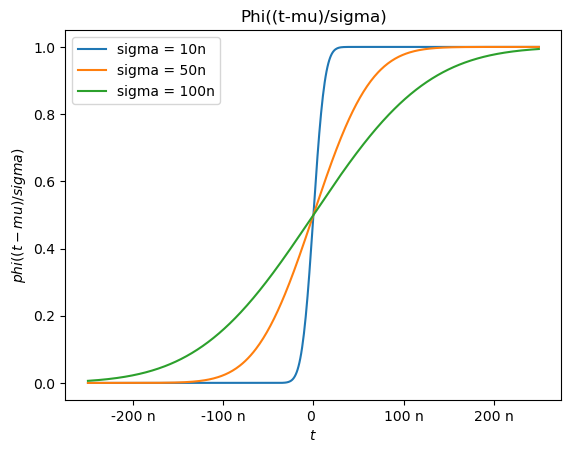

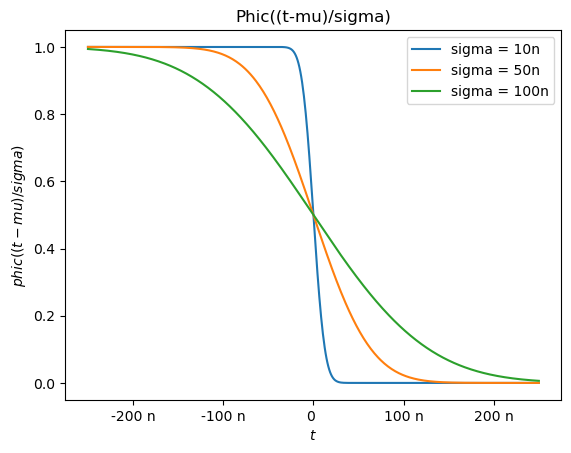

In [3]:
# using the erf to define the gaussian CDF
def phi(t, mu, sigma):
    return 1/2 * (1 + special.erf((t - mu)/(sigma * np.sqrt(2))))

# using the erfc to define the gaussian CDFc
def phic(t, mu, sigma):
    return 1/2 * (special.erfc((t - mu)/(sigma * np.sqrt(2))))# it needed to - 1 to keep the simetry

t = np.linspace(-250 *10**(-9), 250 *10**(-9), num = 500)
mu = 0
sigma = 10 * 10**(-9)
sigma2 = 50 * 10**(-9)
sigma3 = 100 * 10**(-9)

plt.plot(t, phi(t, mu, sigma), label = 'sigma = 10n')
plt.plot(t, phi(t, mu, sigma2), label = 'sigma = 50n')
plt.plot(t, phi(t, mu, sigma3), label = 'sigma = 100n')

plt.xlabel('$t$')
plt.ylabel('$phi((t-mu)/sigma)$')
plt.title('Phi((t-mu)/sigma)')
plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

plt.plot(t, phic(t, mu, sigma), label = 'sigma = 10n')
plt.plot(t, phic(t, mu, sigma2), label = 'sigma = 50n')
plt.plot(t, phic(t, mu, sigma3), label = 'sigma = 100n')

plt.xlabel('$t$')
plt.ylabel('$phic((t-mu)/sigma)$')
plt.title('Phic((t-mu)/sigma)')
plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

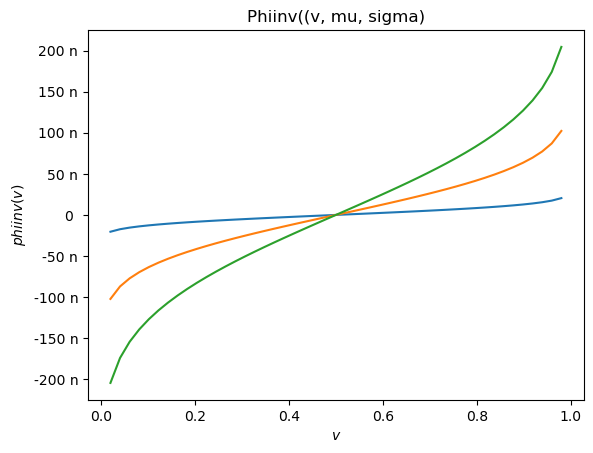

In [4]:
# using the erfinv to define the ineverse of the gaussian CDF

def phiinv(v, mu, sigma):
    return mu + sigma * (np.sqrt(2) * special.erfinv( 2 * v - 1))

v = np.linspace(0, 1)
mu = 0
sigma = 10 * 10**(-9)
sigma2 = 50 * 10**(-9)
sigma3 = 100 * 10**(-9)

plt.plot(v, phiinv(v, mu, sigma), label = 'sigma = 0.1')
plt.plot(v, phiinv(v, mu, sigma2), label = 'sigma = 0.5')
plt.plot(v, phiinv(v, mu, sigma3), label = 'sigma = 1')

plt.xlabel('$v$')
plt.ylabel('$phiinv(v)$')
plt.title('Phiinv((v, mu, sigma)')

##### Define the formatter function for y-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_y_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to y-axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
#####

plt.show()

In [5]:
mu = 0
sigma = 10 * 10**(-9)

def risetime_10_90(mu, sigma):
    return phiinv(0.9, mu, sigma) - phiinv(0.1, mu, sigma)
    
risetime_10_90(mu, sigma)

2.563103131089201e-08

So, lets define 3 pulses for this analysis with different rise times: 50ns, 100ns and 200ns. First, lets plot the relatioship between sigma and the risetime:

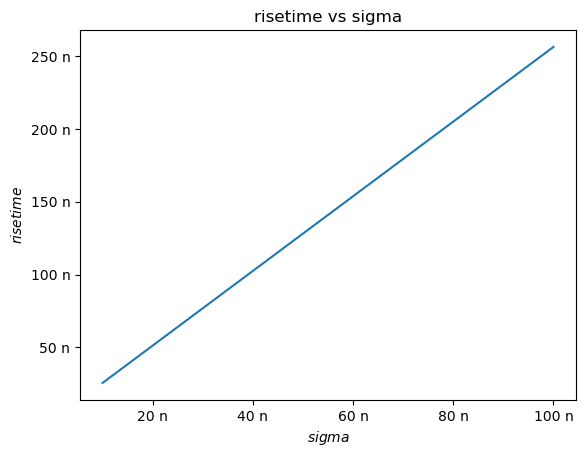

In [6]:
delta_sigma = np.linspace(10 * 10**(-9), 100 * 10**(-9), num = 5)

plt.plot(delta_sigma, risetime_10_90(0, delta_sigma))

plt.xlabel('$sigma$')
plt.ylabel('$risetime$')
plt.title('risetime vs sigma')

##### Define the formatter function for y-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_y_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to y-axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
#####
##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

Looking the above graph to find an inital guess and playing a bit we can find below sigmas for our 50ns, 100ns and 200ns pulses.

In [7]:
risetime_10_90(0, 19.51 * 10**(-9)) #by inspection, RT=50ns can be obtained from sigma=19.51n

5.000614208755033e-08

In [8]:
risetime_10_90(0, 39.016 * 10**(-9)) #by inspection, RT=100ns can be obtained from sigma=39.016n

1.0000203176257628e-07

In [9]:
risetime_10_90(0, 78.032 * 10**(-9)) #by inspection, RT=200ns can be obtained from sigma=78.032n

2.0000406352515255e-07

Then we can plot the 50ns, 100ns and 200ns pulses:

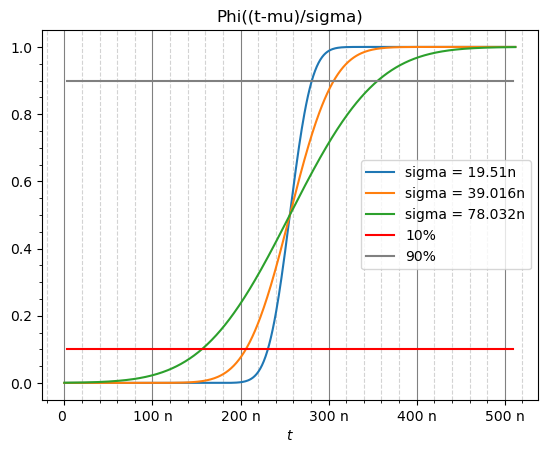

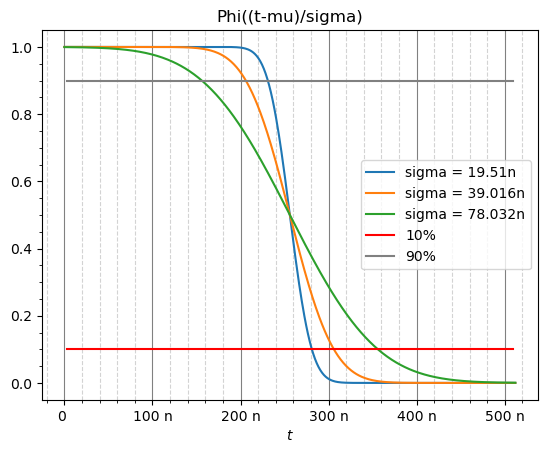

In [31]:
t = np.linspace(0, 512 *10**(-9), num = 512)
mu = 256 * 10**(-9)
sigma = 19.51 * 10**(-9)
sigma2 = 39.016 * 10**(-9)
sigma3 = 78.032 * 10**(-9)

rt50 = phi(t, mu, sigma)
rt100 = phi(t, mu, sigma2)
rt200 = phi(t, mu, sigma3)

plt.plot(t, rt50, label = 'sigma = 19.51n')
plt.plot(t, rt100, label = 'sigma = 39.016n')
plt.plot(t, rt200, label = 'sigma = 78.032n')

plt.axhline(0.1, 0.05, 0.95, color = 'red', label = '10%')
plt.axhline(0.9, 0.05, 0.95, color = 'gray', label = '90%')

plt.minorticks_on()
plt.grid(visible = True, which = 'major', axis = 'x', color = 'gray')
plt.grid(visible = True, which = 'minor', axis = 'x', color = 'lightgray', linestyle='--')
plt.xlabel('$t$')
#plt.ylabel('$phi((t-mu)/sigma)$')
plt.title('Phi((t-mu)/sigma)')
plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

rt50c = phic(t, mu, sigma)
rt100c = phic(t, mu, sigma2)
rt200c = phic(t, mu, sigma3)

plt.plot(t, rt50c, label = 'sigma = 19.51n')
plt.plot(t, rt100c, label = 'sigma = 39.016n')
plt.plot(t, rt200c, label = 'sigma = 78.032n')

plt.axhline(0.1, 0.05, 0.95, color = 'red', label = '10%')
plt.axhline(0.9, 0.05, 0.95, color = 'gray', label = '90%')

plt.minorticks_on()
plt.grid(visible = True, which = 'major', axis = 'x', color = 'gray')
plt.grid(visible = True, which = 'minor', axis = 'x', color = 'lightgray', linestyle='--')
plt.xlabel('$t$')
#plt.ylabel('$phi((t-mu)/sigma)$')
plt.title('Phi((t-mu)/sigma)')
plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

Now lets create a "square" pulse:

In [79]:
from scipy.fft import fft, rfft, fftfreq
from scipy.signal import windows
import numpy as np
import matplotlib.pyplot as plt

In [32]:
from scipy.fft import fft, rfft, fftfreq
from scipy.signal import windows
import numpy as np
import matplotlib.pyplot as plt

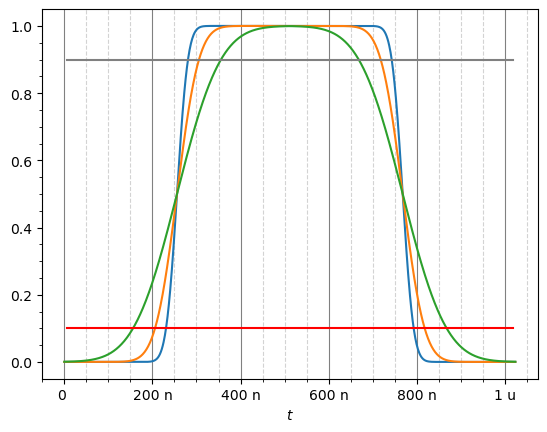

In [33]:
t = np.linspace(0, 1024 *10**(-9), num = 1024)
rt50d = np.concatenate([rt50, np.flip(rt50)])
rt100d = np.concatenate([rt100, np.flip(rt100)])
rt200d = np.concatenate([rt200, np.flip(rt200)])

plt.plot(t, rt50d, label = 'sigma = 19.51n')
plt.plot(t, rt100d, label = 'sigma = 39.016n')
plt.plot(t, rt200d, label = 'sigma = 78.032n')

plt.axhline(0.1, 0.05, 0.95, color = 'red', label = '10%')
plt.axhline(0.9, 0.05, 0.95, color = 'gray', label = '90%')

plt.minorticks_on()
plt.grid(visible = True, which = 'major', axis = 'x', color = 'gray')
plt.grid(visible = True, which = 'minor', axis = 'x', color = 'lightgray', linestyle='--')
plt.xlabel('$t$')
#plt.ylabel('$phi((t-mu)/sigma)$')
#plt.title('Phi((t-mu)/sigma)')
#plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

And, from the "square" pulse we creta a pulse train:

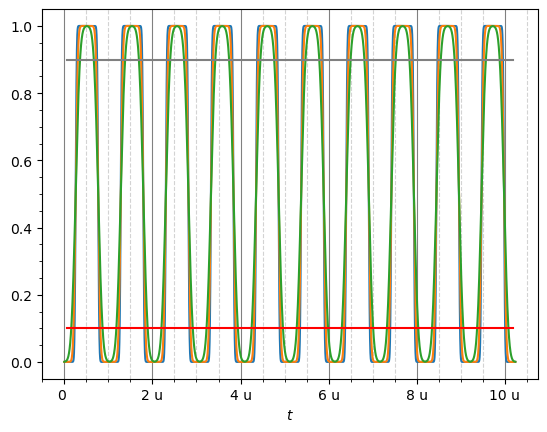

In [34]:
i = 10 # number of repeated periods

rt50t = np.copy(rt50d)
rt100t = np.copy(rt100d)
rt200t = np.copy(rt200d)

for x in range(i-1):
    rt50t = np.concatenate([rt50t, rt50d])
    rt100t = np.concatenate([rt100t, rt100d])
    rt200t = np.concatenate([rt200t, rt200d])

t = np.linspace(0, i * 1024 *10**(-9), num = i * 1024)

plt.plot(t, rt50t, label = 'sigma = 19.51n')
plt.plot(t, rt100t, label = 'sigma = 39.016n')
plt.plot(t, rt200t, label = 'sigma = 78.032n')

plt.axhline(0.1, 0.05, 0.95, color = 'red', label = '10%')
plt.axhline(0.9, 0.05, 0.95, color = 'gray', label = '90%')

plt.minorticks_on()
plt.grid(visible = True, which = 'major', axis = 'x', color = 'gray')
plt.grid(visible = True, which = 'minor', axis = 'x', color = 'lightgray', linestyle='--')
plt.xlabel('$t$')
#plt.ylabel('$phi((t-mu)/sigma)$')
#plt.title('Phi((t-mu)/sigma)')
#plt.legend()

##### Define the formatter function for x-axis ticks
#Courtesy of ChatGPT
from matplotlib.ticker import FuncFormatter
def format_x_ticks(value, _):
    prefixes = ['p', 'n', 'u', 'm', '', 'k', 'M', 'G', 'T']  # Add more prefixes if needed
    if value == 0:
        prefix_index = 4
    else:
        prefix_index = int(np.floor(np.log10(abs(value)) / 3)) + 4
    prefix = prefixes[prefix_index]
    scaled_value = value / 10**((prefix_index - 4) * 3)
    return f'{scaled_value:g} {prefix}'
# Apply the formatter to x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
#####

plt.show()

Once the pulses are defined and the risetimes obtained, it is time to look at the spectral content of them using the [fft](https://docs.scipy.org/doc/scipy/tutorial/fft.html).

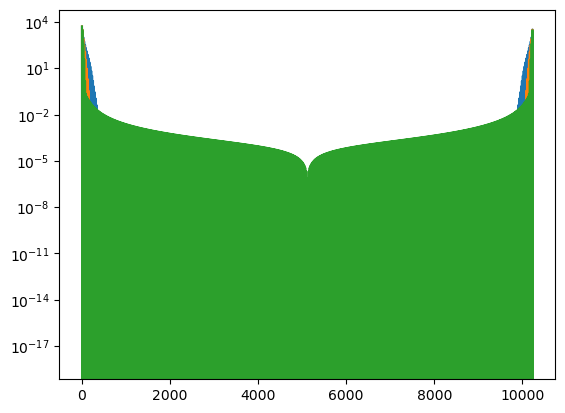

In [36]:
N = 100 # number of samples
P = 0.4 # total time window of the signal in us
t = np.linspace(0, P, num = N, endpoint = False) # 100 points spaced between 0 and 0.4us
T = P/N # sampling period
mu = P/2
sigma = 0.01951

plt.semilogy(np.abs(fft(rt50t))) # [:N//2] -> plotting just the 1st half of the fft which represents the positive values
plt.semilogy(np.abs(fft(rt100t)))
plt.semilogy(np.abs(fft(rt200t)))
plt.show()

<a id="ref_1"></a>
[1] Bandwidth of Signals: What is Important, Rise Time or Slew Rate? - https://www.signalintegrityjournal.com/articles/2092-bandwidth-of-signals-what-is-important-rise-time-or-slew-rate?page=2

<a id='ref_2'></a>
[2] Normal distribution - https://en.wikipedia.org/wiki/Normal_distribution

<a id='ref_3'></a>
[3] SciPy documentation - https://docs.scipy.org/doc/scipy/index.html